Custom GAN image generation code

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
import random


np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


dataset_path = '/content/drive/MyDrive/Dataset'


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

#dataset to include image paths and labels
class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []

        parkinson_path = os.path.join(root, 'Parkinson')
        healthy_path = os.path.join(root, 'Healthy')

        for label, class_path in enumerate([parkinson_path, healthy_path]):
            for fname in os.listdir(class_path):
                self.samples.append((os.path.join(class_path, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


def create_dataloader(dataset, label, batch_size=8):
    class_indices = [i for i, (_, lbl) in enumerate(dataset.samples) if lbl == label]
    class_subset = torch.utils.data.Subset(dataset, class_indices)
    return DataLoader(class_subset, batch_size=batch_size, shuffle=True, num_workers=2)

#loading dataset
dataset = CustomImageFolder(root=dataset_path, transform=transform)
batch_size = 8

#generator and discriminator architectures
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


generator = Generator().to(device)
discriminator = Discriminator().to(device)

#initializing optimizers with  learning rates
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

#loss functions
criterion_GAN = nn.BCELoss().to(device)
criterion_content = nn.L1Loss().to(device)

#directories to save results
results_dir_parkinson = '/content/drive/MyDrive/SRGANTRIALWORKSEED/Parkinson'
results_dir_healthy = '/content/drive/MyDrive/SRGANTRIALWORKSEED/Healthy'
os.makedirs(results_dir_parkinson, exist_ok=True)
os.makedirs(results_dir_healthy, exist_ok=True)

# Training function
def train_model(data_loader, results_dir, num_epochs=20, initial_lr=0.0001, lr_decay_epoch=10):
    optimizer_G.param_groups[0]['lr'] = initial_lr  #initial LR for generator
    optimizer_D.param_groups[0]['lr'] = initial_lr  # initial LR for discriminator

    for epoch in range(num_epochs):
        if epoch > lr_decay_epoch:
            #reducing learning rate after lr_decay_epoch
            new_lr = initial_lr * (0.1 ** ((epoch - lr_decay_epoch) // 10))
            optimizer_D.param_groups[0]['lr'] = new_lr

        for i, (imgs, labels) in enumerate(data_loader):


            imgs_lr = imgs.to(device)
            labels = labels.to(device)

            #training Discriminator
            optimizer_D.zero_grad()

            gen_hr = generator(imgs_lr)

            #calculating discriminator loss with label smoothing
            valid = torch.ones(imgs_lr.size(0), 1, device=device) * 0.9  #labels for real images with label smoothing
            fake = torch.zeros(imgs_lr.size(0), 1, device=device)  #labels for fake images

            real_loss = criterion_GAN(discriminator(imgs_lr), valid)  #loss on real images
            fake_loss = criterion_GAN(discriminator(gen_hr.detach()), fake)  #loss on generated images

            d_loss = (real_loss + fake_loss) / 2  #total discriminator loss

            d_loss.backward()
            optimizer_D.step()

            #training generator
            optimizer_G.zero_grad()

            gen_hr = generator(imgs_lr)

            #calculating generator loss
            g_loss_content = criterion_content(gen_hr, imgs_lr)  #content loss

            #adversarial loss
            fake_validity = discriminator(gen_hr)
            g_loss_GAN = criterion_GAN(fake_validity, valid)

            g_loss = g_loss_content + 1e-3 * g_loss_GAN  #total generator loss

            g_loss.backward()
            optimizer_G.step()

            #losses printed
            if i % 100 == 0:
                print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(data_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

            #generated images saved after the 10th epoch
            if epoch >= 10:
                for k in range(imgs_lr.size(0)):
                    save_path = os.path.join(results_dir, f"epoch_{epoch}_batch_{i}_img_{k}.png")
                    save_image(gen_hr[k], save_path, normalize=True)


parkinson_loader = create_dataloader(dataset, label=0, batch_size=batch_size)
healthy_loader = create_dataloader(dataset, label=1, batch_size=batch_size)

#train model for each class
print("Training for Parkinson class...")
train_model(parkinson_loader, results_dir_parkinson, num_epochs=20)
print("Training for Healthy class...")
train_model(healthy_loader, results_dir_healthy, num_epochs=20)

print("Finished training and saved images.")


Training for Parkinson class...
[Epoch 0/20] [Batch 0/204] [D loss: 0.7895] [G loss: 0.7247]
[Epoch 0/20] [Batch 100/204] [D loss: 0.1698] [G loss: 0.0854]
[Epoch 0/20] [Batch 200/204] [D loss: 0.1885] [G loss: 0.0471]
[Epoch 1/20] [Batch 0/204] [D loss: 0.2705] [G loss: 0.0528]
[Epoch 1/20] [Batch 100/204] [D loss: 0.5476] [G loss: 0.0570]
[Epoch 1/20] [Batch 200/204] [D loss: 0.2236] [G loss: 0.0369]
[Epoch 2/20] [Batch 0/204] [D loss: 0.2095] [G loss: 0.0393]
[Epoch 2/20] [Batch 100/204] [D loss: 0.1886] [G loss: 0.0362]
[Epoch 2/20] [Batch 200/204] [D loss: 0.1742] [G loss: 0.0403]
[Epoch 3/20] [Batch 0/204] [D loss: 0.2032] [G loss: 0.0457]
[Epoch 3/20] [Batch 100/204] [D loss: 0.1701] [G loss: 0.0509]
[Epoch 3/20] [Batch 200/204] [D loss: 0.1810] [G loss: 0.0321]
[Epoch 4/20] [Batch 0/204] [D loss: 0.1696] [G loss: 0.0405]
[Epoch 4/20] [Batch 100/204] [D loss: 0.2085] [G loss: 0.0612]
[Epoch 4/20] [Batch 200/204] [D loss: 0.1974] [G loss: 0.0314]
[Epoch 5/20] [Batch 0/204] [D los

In [ ]:
import os

def count_images_in_directory(directory):
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}
    count = 0
    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                count += 1
    return count

#base directories
base_real_dir = '/content/drive/MyDrive/Dataset'
base_generated_dir = '/content/drive/MyDrive/SRGANTRIALWORKSEED'


subdirectories = ['Parkinson', 'Healthy']

#counting images in each subdirectory
total_images = 0
for base_dir in [base_real_dir, base_generated_dir]:
    for subdirectory in subdirectories:
        dir_path = os.path.join(base_dir, subdirectory)
        count = count_images_in_directory(dir_path)
        total_images += count
        print(f"Number of images in {dir_path}: {count}")


print(f"Total images in both directories: {total_images}")


Number of images in /content/drive/MyDrive/Dataset/Parkinson: 1632
Number of images in /content/drive/MyDrive/Dataset/Healthy: 1632
Number of images in /content/drive/MyDrive/SRGANTRIALWORKSEED/Parkinson: 16320
Number of images in /content/drive/MyDrive/SRGANTRIALWORKSEED/Healthy: 16320
Total images in both directories: 35904


 SSIM

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np

#resizing images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

#loading images from directory and resizing
class CustomImageFolder(Dataset):
    def __init__(self, root, class_name, transform=None):
        self.root = root
        self.class_name = class_name
        self.transform = transform
        self.samples = []
        class_path = os.path.join(root, class_name)

        #checking if  directory exists
        if os.path.isdir(class_path):
            print(f"Found directory: {class_path}")
        else:
            print(f"Directory not found: {class_path}")

        for fname in os.listdir(class_path):
            self.samples.append(os.path.join(class_path, fname))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

def calculate_ssim(images1, images2, win_size=3, data_range=1.0):
    ssim_sum = 0.0
    num_images = min(len(images1), len(images2))

    for i in range(num_images):
        img1 = images1[i].permute(1, 2, 0).numpy()  #converting to numpy and reshaping
        img2 = images2[i].permute(1, 2, 0).numpy()
        #print(f"Comparing images of shape: {img1.shape} and {img2.shape}")
        ssim_sum += compare_ssim(img1, img2, multichannel=True, win_size=win_size, channel_axis=-1, data_range=data_range)

    ssim_avg = ssim_sum / num_images
    return ssim_avg

def calculate_batch_ssim(loader1, loader2, win_size=3, data_range=1.0):
    total_ssim = 0.0
    count = 0
    for batch1, batch2 in zip(loader1, loader2):
        ssim = calculate_ssim(batch1, batch2, win_size=win_size, data_range=data_range)
        total_ssim += ssim * len(batch1)
        count += len(batch1)
    return total_ssim / count


base_real_dir = '/content/drive/MyDrive/Dataset'
base_generated_dir = '/content/drive/MyDrive/SRGANTRIALWORKSEED'


batch_size = 8

#real and generated images resized
real_parkinson_dataset = CustomImageFolder(base_real_dir, 'Parkinson', transform)
generated_parkinson_dataset = CustomImageFolder(base_generated_dir, 'Parkinson', transform)
real_healthy_dataset = CustomImageFolder(base_real_dir, 'Healthy', transform)
generated_healthy_dataset = CustomImageFolder(base_generated_dir, 'Healthy', transform)

real_parkinson_loader = DataLoader(real_parkinson_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
generated_parkinson_loader = DataLoader(generated_parkinson_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
real_healthy_loader = DataLoader(real_healthy_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
generated_healthy_loader = DataLoader(generated_healthy_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

#SSIM for batches
ssim_parkinson = calculate_batch_ssim(real_parkinson_loader, generated_parkinson_loader, win_size=3, data_range=1.0)
ssim_healthy = calculate_batch_ssim(real_healthy_loader, generated_healthy_loader, win_size=3, data_range=1.0)

print(f"SSIM for Parkinson class: {ssim_parkinson:.6f}")
print(f"SSIM for Healthy class: {ssim_healthy:.6f}")


Found directory: /content/drive/MyDrive/Dataset/Parkinson
Found directory: /content/drive/MyDrive/SRGANTRIALWORKSEED/Parkinson
Found directory: /content/drive/MyDrive/Dataset/Healthy
Found directory: /content/drive/MyDrive/SRGANTRIALWORKSEED/Healthy
SSIM for Parkinson class: 0.606148
SSIM for Healthy class: 0.637629


EDA of original and generated

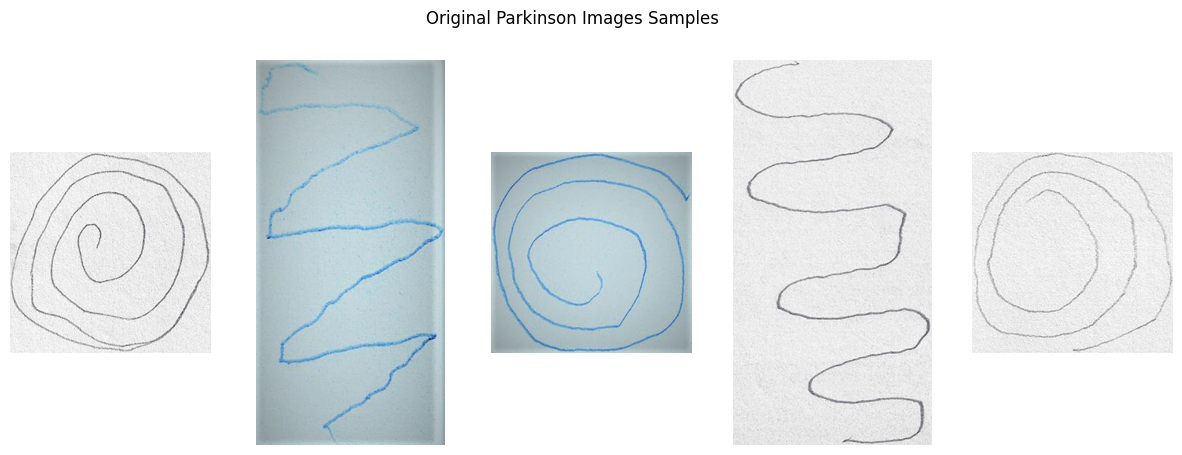

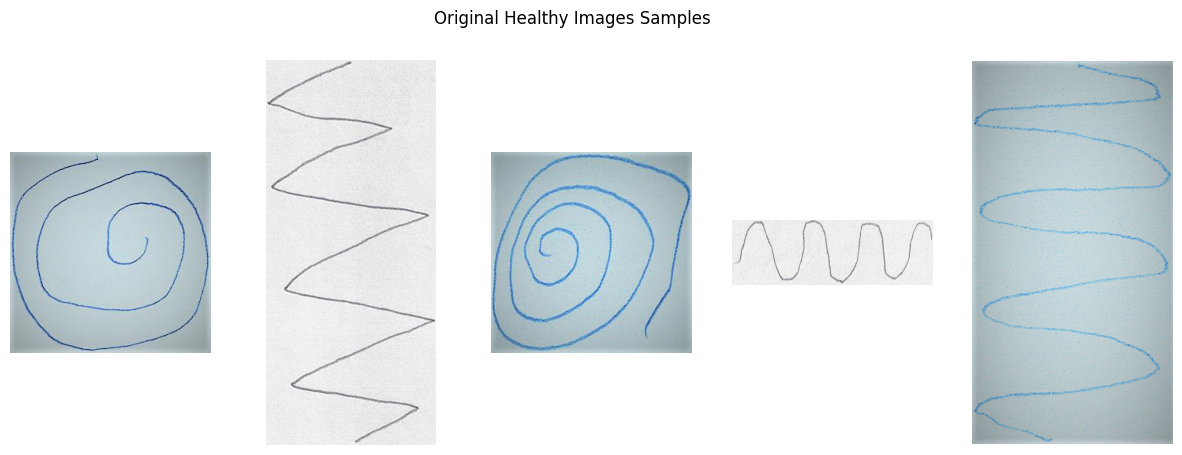

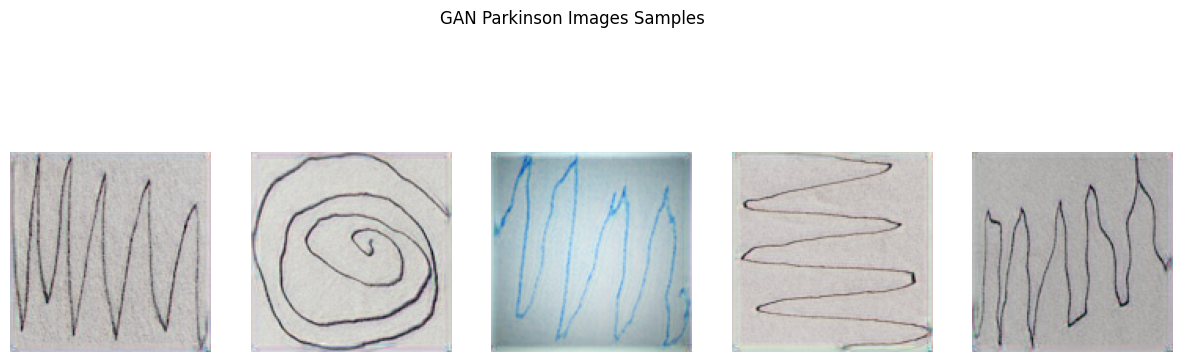

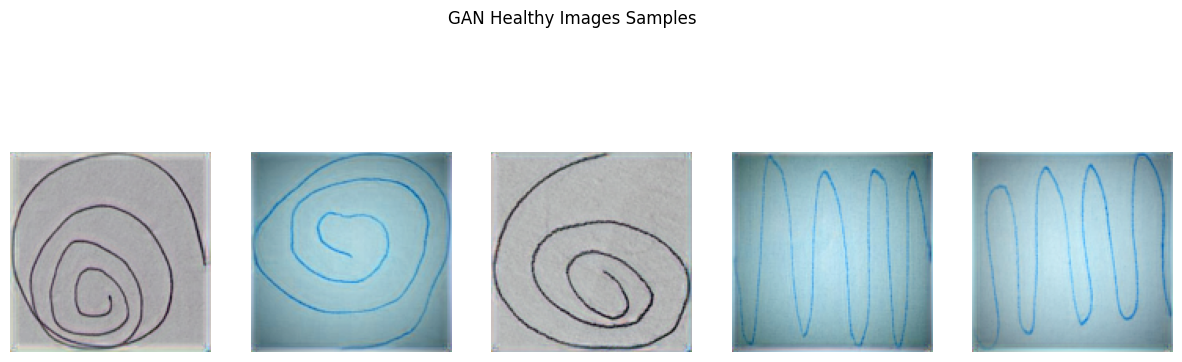

In [ ]:
import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random


base_real_dir = '/content/drive/MyDrive/Dataset'
base_generated_dir = '/content/drive/MyDrive/SRGANTRIALWORKSEED'


subdirectories = ['Parkinson', 'Healthy']

#loading images from a specific directory
def load_images_from_subdirectory(base_dir, subdirectory):
    directory = os.path.join(base_dir, subdirectory)
    image_paths = glob(os.path.join(directory, '*.png'))
    images = [cv2.imread(img_path) for img_path in image_paths]
    return images, image_paths

#original images
original_parkinson_images, original_parkinson_paths = load_images_from_subdirectory(base_real_dir, 'Parkinson')
original_healthy_images, original_healthy_paths = load_images_from_subdirectory(base_real_dir, 'Healthy')

#GAN images
gan_parkinson_images, gan_parkinson_paths = load_images_from_subdirectory(base_generated_dir, 'Parkinson')
gan_healthy_images, gan_healthy_paths = load_images_from_subdirectory(base_generated_dir, 'Healthy')

#display images
def display_images(images, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for img, ax in zip(images, axes):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
    plt.suptitle(title)
    plt.show()


display_images(random.sample(original_parkinson_images, 5), 'Original Parkinson Images Samples')
display_images(random.sample(original_healthy_images, 5), 'Original Healthy Images Samples')
display_images(random.sample(gan_parkinson_images, 5), 'GAN Parkinson Images Samples')
display_images(random.sample(gan_healthy_images, 5), 'GAN Healthy Images Samples')


Creation of GAN combined dataset

In [ ]:
import os
import random
import shutil


random.seed(42)

def get_images_from_directory(directory):
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}
    images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                images.append(os.path.join(root, file))
    return images

def copy_images(images, dest_directory):
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    for subdirectory, image_list in images.items():
        dest_subdir = os.path.join(dest_directory, subdirectory)
        if not os.path.exists(dest_subdir):
            os.makedirs(dest_subdir)
        for image in image_list:
            shutil.copy(image, dest_subdir)


base_real_dir = '/content/drive/MyDrive/Dataset'
base_generated_dir = '/content/drive/MyDrive/SRGANTRIALWORKSEED'
subdirectories = ['Parkinson', 'Healthy']

#destination directory
dest_dir = '/content/drive/MyDrive/SelectedImageFINAL'

#collecting images separately for each category
category_images = {'Parkinson': [], 'Healthy': []}
for subdirectory in subdirectories:
    #collecting images from real directory
    real_dir_path = os.path.join(base_real_dir, subdirectory)
    real_images = get_images_from_directory(real_dir_path)
    category_images[subdirectory].extend(real_images)

    #collecting images from  generated directory
    generated_dir_path = os.path.join(base_generated_dir, subdirectory)
    generated_images = get_images_from_directory(generated_dir_path)
    category_images[subdirectory].extend(generated_images)

#ensuring  enough images in each category
total_images_needed = 7000
images_per_category = total_images_needed // 2
for category, images in category_images.items():
    if len(images) < images_per_category:
        raise ValueError(f"Not enough images in the {category} category to select {images_per_category}. Only found {len(images)} images.")


selected_images = {'Parkinson': [], 'Healthy': []}

for category in subdirectories:
    if category == 'Parkinson':
        #getting all real Parkinson images first
        real_images = [img for img in category_images[category] if base_real_dir in img]

        #selecting all real Parkinson images
        selected_images[category] = real_images[:images_per_category]

        #checking remaining space for Parkinson images
        remaining_space = images_per_category - len(selected_images[category])

        if remaining_space > 0:
            #getting all generated Parkinson images
            generated_images = [img for img in category_images[category] if base_generated_dir in img]

            #appending generated Parkinson images up to the remaining space
            selected_images[category].extend(generated_images[:remaining_space])


            print(f"Used {len(generated_images[:remaining_space])} GAN images for the Parkinson category.")

    elif category == 'Healthy':
        #getting all real Healthy images first
        real_images = [img for img in category_images[category] if base_real_dir in img]

        #selecting all real Healthy images
        selected_images[category] = real_images[:images_per_category]

        #checking remaining space for Healthy images
        remaining_space = images_per_category - len(selected_images[category])

        if remaining_space > 0:
            #getting all generated Healthy images
            generated_images = [img for img in category_images[category] if base_generated_dir in img]

            #appending generated Healthy images up to the remaining space
            selected_images[category].extend(generated_images[:remaining_space])


            print(f"Used {len(generated_images[:remaining_space])} GAN images for the Healthy category.")


copy_images(selected_images, dest_dir)

print(f"Copied {total_images_needed} images to {dest_dir} under their respective folders.")


Used 1868 GAN images for the Parkinson category.
Used 1868 GAN images for the Healthy category.
Copied 7000 images to /content/drive/MyDrive/SelectedImageFINAL under their respective folders.


In [ ]:
import os


dest_dir = '/content/drive/MyDrive/SelectedImageFINAL'


categories = ['Parkinson', 'Healthy']

#storing the count of images for each category
category_image_counts = {}

#iterating over each category to count the images
for category in categories:
    category_path = os.path.join(dest_dir, category)
    if os.path.exists(category_path) and os.path.isdir(category_path):
        image_count = len([name for name in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, name))])
        category_image_counts[category] = image_count
    else:
        category_image_counts[category] = 0


for category, count in category_image_counts.items():
    print(f"{category}: {count} images")


Parkinson: 3500 images
Healthy: 3500 images


RESNet50+KNN

In [ ]:
import os
import numpy as np
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import gc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, cohen_kappa_score,f1_score
from PIL import Image, ImageEnhance


parent_dataset_folder = "/content/drive/MyDrive/SelectedImageFINAL"
subdirectories = ['Parkinson', 'Healthy']

#resizing
target_size = (128, 128)

#preprocessing images
def preprocess_image(image_path):
    image = Image.open(image_path)


    if image.mode == 'RGBA':
        image = image.convert('RGB')


    image = image.resize(target_size)

    #contrast
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.2)

    #normalizing the image array
    image_array = np.array(image) / 255.0

    return image_array


preprocessed_images = []
labels = []

#iterating through each class folder
for class_folder in subdirectories:
    class_folder_path = os.path.join(parent_dataset_folder, class_folder)
    if os.path.isdir(class_folder_path):
        #each image file in the class folder
        for filename in os.listdir(class_folder_path):
            if filename.endswith(".png"):  #images in PNG format
                image_path = os.path.join(class_folder_path, filename)

                #preprocess image
                preprocessed_image = preprocess_image(image_path)


                preprocessed_images.append(preprocessed_image)


                labels.append(class_folder)

#converting to numpy arrays
preprocessed_images = np.array(preprocessed_images)
labels = np.array(labels)

#encoding the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


X_train, X_test, y_train, y_test = train_test_split(preprocessed_images, encoded_labels, test_size=0.2, random_state=42)

#free memory
del preprocessed_images, labels
gc.collect()

#ResNet50 model for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)

#extracting features from the training and test images
def extract_features(images, batch_size=32):
    num_samples = images.shape[0]
    features_list = []
    for i in range(0, num_samples, batch_size):
        batch_images = images[i:i + batch_size]
        features = feature_extractor.predict(batch_images, batch_size=batch_size)
        features_flattened = features.reshape(features.shape[0], -1)
        features_list.append(features_flattened)
    features_full = np.vstack(features_list)
    return features_full

X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

#free memory
del X_train, X_test
gc.collect()

#gridSearchCV
param_grid = {
    'n_neighbors': [3, 5],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}


knn = KNeighborsClassifier()


grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, verbose=1)


grid_search.fit(X_train_features, y_train)

#best parameters found by GridSearchCv
print("Best parameters found: ", grid_search.best_params_)

#training the kNN classifier with the best parameters
best_knn = grid_search.best_estimator_

#predicting labels for the test set using the best kNN classifier
y_test_pred_labels = best_knn.predict(X_test_features)


test_accuracy_manual = accuracy_score(y_test, y_test_pred_labels)
print("Manual accuracy on test data:", test_accuracy_manual)


conf_matrixrk = confusion_matrix(y_test, y_test_pred_labels)
print("Confusion Matrix:")
print(conf_matrixrk)


class_report = classification_report(y_test, y_test_pred_labels, target_names=subdirectories)
print("Classification Report:")
print(class_report)


#sensitivity (recall) for Parkinson (class 1)
TP = conf_matrixrk[0, 0]  #true Positives
FN = conf_matrixrk[0, 1]  #false Negatives
sensitivityrk = TP / (TP + FN) if (TP + FN) > 0 else 0
print("Sensitivity (Recall):", sensitivityrk)

#specificity for Healthy (class 0)
TN = conf_matrixrk[1, 1]  #true Negatives
FP = conf_matrixrk[1, 0]  #false Positives
specificityrk = TN / (TN + FP) if (TN + FP) > 0 else 0
print("Specificity:", specificityrk)


precision_per_class = precision_score(y_test, y_test_pred_labels, average=None)


cohens_kappa = cohen_kappa_score(y_test, y_test_pred_labels)
print("Cohen's Kappa:", cohens_kappa)

overall_precision = np.mean(precision_per_class)
print("Overall Precision:", overall_precision)
f1_per_class = f1_score(y_test, y_test_pred_labels, average=None)
print("F1 Score per class:", f1_per_class)

overall_f1_score = f1_score(y_test, y_test_pred_labels, average='macro')
print("Overall F1 Score (Macro):", overall_f1_score)

1/1 [==============================] - 1s 1s/step
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Manual accuracy on test data: 0.8307142857142857
Confusion Matrix:
[[606  83]
 [154 557]]
Classification Report:
              precision    recall  f1-score   support

   Parkinson       0.80      0.88      0.84       689
     Healthy       0.87      0.78      0.82       711

    accuracy                           0.83      1400
   macro avg       0.83      0.83      0.83      1400
weighted avg       0.83      0.83      0.83      1400

Sensitivity (Recall): 0.8795355587808418
Specificity: 0.7834036568213784
Cohen's Kappa: 0.6618839929890352
Overall Precision: 0.8338404605263159
F1 Score per class: [0.83643892 0.82457439]
Overall F1 Score (Macro): 0.830506656368337


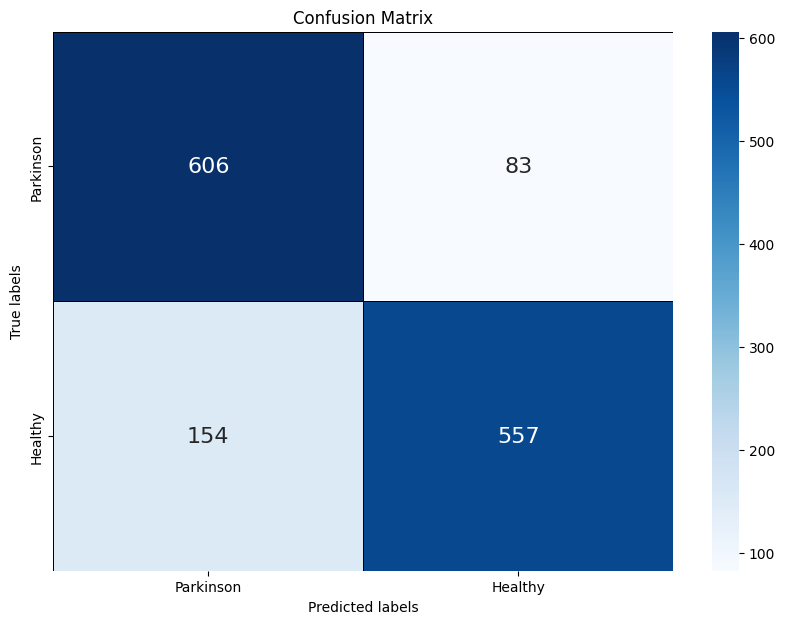

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(y_test, y_test_pred_labels)


import pandas as pd
conf_matrix_df = pd.DataFrame(conf_matrix, index=subdirectories, columns=subdirectories)

#plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            annot_kws={"size": 16}, linewidths=.5, linecolor='black')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


InceptionV3+KNN

In [ ]:
import os
import numpy as np
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import tensorflow as tf


parent_dataset_folder = "/content/drive/MyDrive/SelectedImageFINAL"
subdirectories = ['Parkinson', 'Healthy']


target_size = (224, 224)


def preprocess_image(image_path):
    image = Image.open(image_path)


    if image.mode == 'RGBA':
        image = image.convert('RGB')


    image = image.resize(target_size)

    #contrast
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.2)

    #normalizing the image array
    image_array = np.array(image) / 255.0

    return image_array


preprocessed_images = []
labels = []


for class_folder in os.listdir(parent_dataset_folder):
    class_folder_path = os.path.join(parent_dataset_folder, class_folder)
    if os.path.isdir(class_folder_path):

        for filename in os.listdir(class_folder_path):
            if filename.endswith(".png"):
                image_path = os.path.join(class_folder_path, filename)

                #preprocess image
                preprocessed_image = preprocess_image(image_path)


                preprocessed_images.append(preprocessed_image)


                labels.append(class_folder)


preprocessed_images = np.array(preprocessed_images)
labels = np.array(labels)


label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


X_train, X_test, y_train, y_test = train_test_split(preprocessed_images, encoded_labels, test_size=0.2, random_state=42)

#InceptionV3 model for feature extraction
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)

#extracting features from the training and test images
def extract_features(images):
    features = feature_extractor.predict(images)
    #flatten the features
    features_flattened = features.reshape(features.shape[0], -1)
    return features_flattened

X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

#parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

#kNN classifier
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_features, y_train)

#best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

#training the kNN classifier with the best hyperparameters
knn_best = KNeighborsClassifier(**best_params)
knn_best.fit(X_train_features, y_train)

#predicting labels for the test set using the kNN classifier
y_test_pred_labels = knn_best.predict(X_test_features)


test_accuracyik = accuracy_score(y_test, y_test_pred_labels)
print("Test accuracy:", test_accuracyik)

conf_matrixik = confusion_matrix(y_test, y_test_pred_labels)
print("Confusion Matrix:")
print(conf_matrixik)

class_report = classification_report(y_test, y_test_pred_labels, target_names=subdirectories)
print("Classification Report:")
print(class_report)

#sensitivity (recall) for Parkinson (class 1)
TP = conf_matrixik[0, 0]
FN = conf_matrixik[0, 1]
sensitivityik = TP / (TP + FN) if (TP + FN) > 0 else 0
print("Sensitivity (Recall):", sensitivityik)

#specificity for Healthy (class 0)
TN = conf_matrixik[1, 1]
FP = conf_matrixik[1, 0]
specificityik = TN / (TN + FP) if (TN + FP) > 0 else 0
print("Specificity:", specificityik)

precision_per_class = precision_score(y_test, y_test_pred_labels, average=None)

cohens_kappa = cohen_kappa_score(y_test, y_test_pred_labels)
print("Cohen's Kappa:", cohens_kappa)

overall_precision = np.mean(precision_per_class)
print("Overall Precision:", overall_precision)


44/44 [==============================] - 9s 177ms/step


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Test accuracy: 0.9214285714285714
Confusion Matrix:
[[672  17]
 [ 93 618]]
Classification Report:
              precision    recall  f1-score   support

   Parkinson       0.88      0.98      0.92       689
     Healthy       0.97      0.87      0.92       711

    accuracy                           0.92      1400
   macro avg       0.93      0.92      0.92      1400
weighted avg       0.93      0.92      0.92      1400

Sensitivity (Recall): 0.9753265602322206
Specificity: 0.869198312236287
Cohen's Kappa: 0.8430861090449651
Overall Precision: 0.9258298595028562


In [ ]:
f1_per_class = f1_score(y_test, y_test_pred_labels, average=None)
print("F1 Score per class:", f1_per_class)

overall_f1_score = f1_score(y_test, y_test_pred_labels, average='macro')
print("Overall F1 Score (Macro):", overall_f1_score)

F1 Score per class: [0.92434663 0.91827637]
Overall F1 Score (Macro): 0.9213115022145193


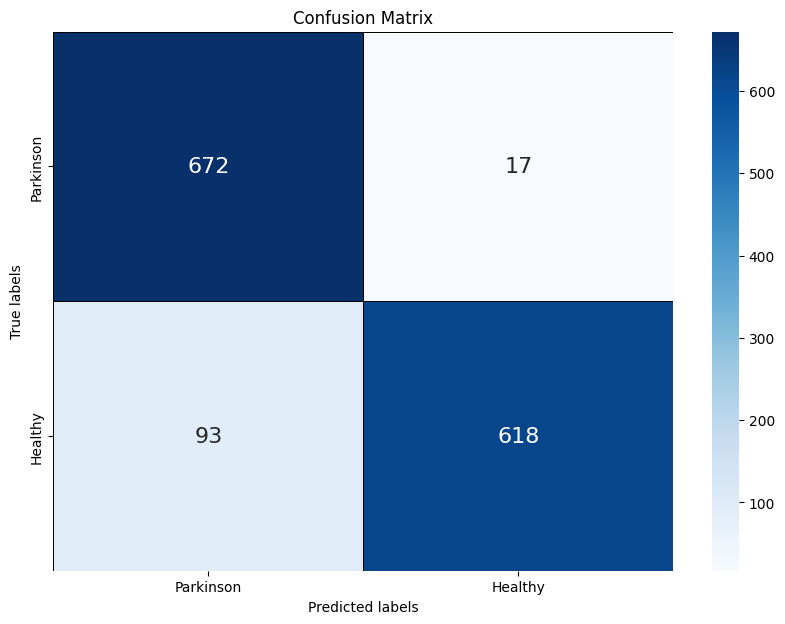

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_test_pred_labels)

import pandas as pd
conf_matrix_df = pd.DataFrame(conf_matrix, index=subdirectories, columns=subdirectories)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            annot_kws={"size": 16}, linewidths=.5, linecolor='black')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


InceptionV3

In [ ]:
import random
import os
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from PIL import Image, ImageEnhance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, cohen_kappa_score,f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, cohen_kappa_score

parent_dataset_folder = "/content/drive/MyDrive/SelectedImageFINAL"
subdirectories = ['Parkinson', 'Healthy']

target_size = (224, 224)

def preprocess_image(image_path):
    image = Image.open(image_path)

    if image.mode == 'RGBA':
        image = image.convert('RGB')

    image = image.resize(target_size)

    #contrast
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.2)

    image_array = np.array(image) / 255.0

    return image_array

#preprocess images
preprocessed_images = []
labels = []

for class_folder in subdirectories:
    class_folder_path = os.path.join(parent_dataset_folder, class_folder)
    if os.path.isdir(class_folder_path):
        for filename in os.listdir(class_folder_path):
            if filename.endswith(".png"):
                image_path = os.path.join(class_folder_path, filename)
                preprocessed_image = preprocess_image(image_path)
                preprocessed_images.append(preprocessed_image)
                labels.append(class_folder)

preprocessed_images = np.array(preprocessed_images)
labels = np.array(labels)


label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


X_train, X_test, y_train, y_test = train_test_split(preprocessed_images, encoded_labels, test_size=0.2, random_state=42)

#tensorFlow datasets
batch_size = 16
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

#InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

#unfreezing top layers of the model for finetuning
for layer in base_model.layers[-20:]:
    layer.trainable = True


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(subdirectories), activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_ds, epochs=10)

test_loss, test_accuracyinc = model.evaluate(test_ds)
print(f"Accuracy on test data: {test_accuracyinc}")

y_test_pred = model.predict(test_ds)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)


print("Manual accuracy on test data:", accuracy_score(y_test, y_test_pred_labels))
print("Confusion Matrix:")
conf_matrixinc = confusion_matrix(y_test, y_test_pred_labels)
print(conf_matrixinc)
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels, target_names=subdirectories))

#sensitivity (recall) for Parkinson (class 1)
TP = conf_matrixinc[0, 0]  # True Positives
FN = conf_matrixinc[0, 1]  # False Negatives
sensitivityinc = TP / (TP + FN) if (TP + FN) > 0 else 0
print("Sensitivity (Recall):", sensitivityinc)

#specificity for Healthy (class 0)
TN = conf_matrixinc[1, 1]  # True Negatives
FP = conf_matrixinc[1, 0]  # False Positives
specificityinc = TN / (TN + FP) if (TN + FP) > 0 else 0
print("Specificity:", specificityinc)

precision_per_class = precision_score(y_test, y_test_pred_labels, average=None)

cohens_kappa = cohen_kappa_score(y_test, y_test_pred_labels)
print("Cohen's Kappa:", cohens_kappa)

overall_precision = np.mean(precision_per_class)
print("Overall Precision:", overall_precision)

f1_per_class = f1_score(y_test, y_test_pred_labels, average=None)
print("F1 Score per class:", f1_per_class)

overall_f1_score = f1_score(y_test, y_test_pred_labels, average='macro')
print("Overall F1 Score (Macro):", overall_f1_score)

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/10
350/350 [==============================] - 258s 688ms/step - loss: 0.3457 - accuracy: 0.8445
Epoch 2/10
350/350 [==============================] - 234s 669ms/step - loss: 0.1331 - accuracy: 0.9502
Epoch 3/10
350/350 [==============================] - 232s 663ms/step - loss: 0.0699 - accuracy: 0.9727
Epoch 4/10
350/350 [==============================] - 231s 661ms/step - loss: 0.0356 - accuracy: 0.9882
Epoch 5/10
350/350 [==============================] - 231s 659ms/step - loss: 0.0469 - accuracy: 0.9846
Epoch 6/10
350/350 [==============================] - 232s 662ms/step - loss: 0.0374 - accuracy: 0.9875
Epoch 7/10
350/350 [==============================] - 231s 659ms/step - loss: 0.0381 - accuracy: 0.9862
Epoch 8/10
350/350 [==============================] - 230s 658ms/step - loss: 0.0170 - accuracy: 0.9945
Epoch 9/10
350/350 [==============================] - 230s 657ms/step - loss: 0.0062 - accuracy: 0.9982

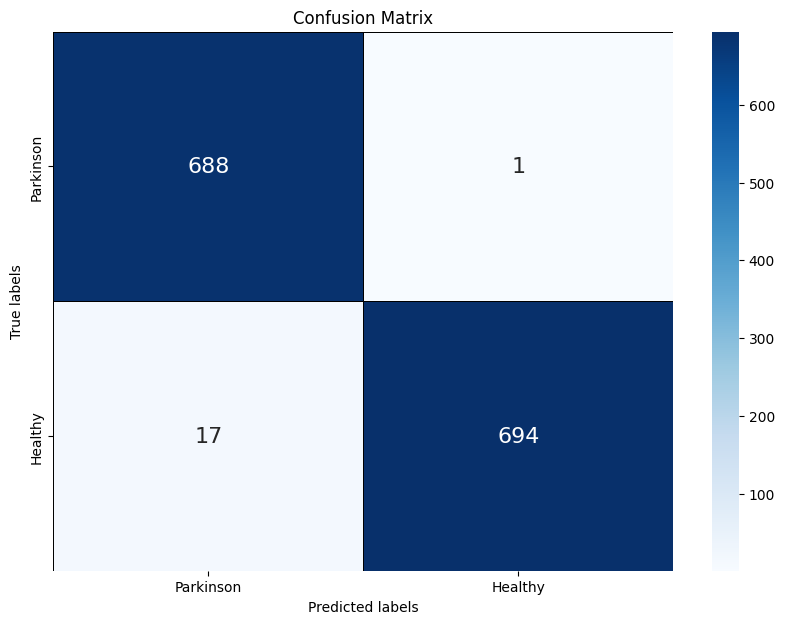

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


conf_matrixinc = confusion_matrix(y_test, y_test_pred_labels)

import pandas as pd
conf_matrix_df = pd.DataFrame(conf_matrixinc, index=subdirectories, columns=subdirectories)


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            annot_kws={"size": 16}, linewidths=.5, linecolor='black')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


ResNet50

In [ ]:
import os
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, cohen_kappa_score
from PIL import Image, ImageEnhance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, cohen_kappa_score, f1_score


parent_dataset_folder = "/content/drive/MyDrive/SelectedImageFINAL"
subdirectories = ['Parkinson', 'Healthy']


target_size = (224, 224)


def preprocess_image(image_path):
    image = Image.open(image_path)

    if image.mode == 'RGBA':
        image = image.convert('RGB')

    image = image.resize(target_size)

    #contrast
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.2)

    image_array = np.array(image) / 255.0

    return image_array

preprocessed_images = []
labels = []

for class_folder in subdirectories:
    class_folder_path = os.path.join(parent_dataset_folder, class_folder)
    if os.path.isdir(class_folder_path):
        for filename in os.listdir(class_folder_path):
            if filename.endswith(".png"):
                image_path = os.path.join(class_folder_path, filename)
                preprocessed_image = preprocess_image(image_path)
                preprocessed_images.append(preprocessed_image)
                labels.append(class_folder)

preprocessed_images = np.array(preprocessed_images)
labels = np.array(labels)


label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


X_train, X_test, y_train, y_test = train_test_split(preprocessed_images, encoded_labels, test_size=0.2, random_state=42)

#tensorFlow datasets
batch_size = 16
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

#unfreezing the top layers of the model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(subdirectories), activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=10)

test_loss, test_accuracyres = model.evaluate(test_ds)
print(f"Accuracy on test data: {test_accuracyres}")

y_test_pred = model.predict(test_ds)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

print("Manual accuracy on test data:", accuracy_score(y_test, y_test_pred_labels))
print("Confusion Matrix:")
conf_matrix_res = confusion_matrix(y_test, y_test_pred_labels)
print(conf_matrix_res)
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels, target_names=subdirectories))

#sensitivity (recall) for Parkinson (class 1)
TP = conf_matrix_res[0, 0]
FN = conf_matrix_res[0, 1]
sensitivityres = TP / (TP + FN) if (TP + FN) > 0 else 0
print("Sensitivity (Recall):", sensitivityres)

#specificity for Healthy (class 0)
TN = conf_matrix_res[1, 1]
FP = conf_matrix_res[1, 0]
specificityres = TN / (TN + FP) if (TN + FP) > 0 else 0
print("Specificity:", specificityres)

precision_per_class = precision_score(y_test, y_test_pred_labels, average=None)
print("Precision per class:", precision_per_class)

cohens_kappa = cohen_kappa_score(y_test, y_test_pred_labels)
print("Cohen's Kappa:", cohens_kappa)

overall_precision = np.mean(precision_per_class)
print("Overall Precision:", overall_precision)

f1_per_class = f1_score(y_test, y_test_pred_labels, average=None)
print("F1 Score per class:", f1_per_class)

overall_f1_score = f1_score(y_test, y_test_pred_labels, average='macro')
print("Overall F1 Score (Macro):", overall_f1_score)


Epoch 1/10
350/350 [==============================] - 369s 1s/step - loss: 0.3051 - accuracy: 0.8680
Epoch 2/10
350/350 [==============================] - 352s 1s/step - loss: 0.0968 - accuracy: 0.9611
Epoch 3/10
350/350 [==============================] - 351s 1s/step - loss: 0.0540 - accuracy: 0.9787
Epoch 4/10
350/350 [==============================] - 350s 1s/step - loss: 0.0663 - accuracy: 0.9779
Epoch 5/10
350/350 [==============================] - 349s 997ms/step - loss: 0.0361 - accuracy: 0.9880
Epoch 6/10
350/350 [==============================] - 349s 998ms/step - loss: 0.0306 - accuracy: 0.9886
Epoch 7/10
350/350 [==============================] - 350s 1s/step - loss: 0.0128 - accuracy: 0.9961
Epoch 8/10
350/350 [==============================] - 351s 1s/step - loss: 0.0337 - accuracy: 0.9902
Epoch 9/10
350/350 [==============================] - 351s 1s/step - loss: 0.0524 - accuracy: 0.9825
Epoch 10/10
88/88 [==============================] - 24s 249ms/step - loss: 0.0999 - 

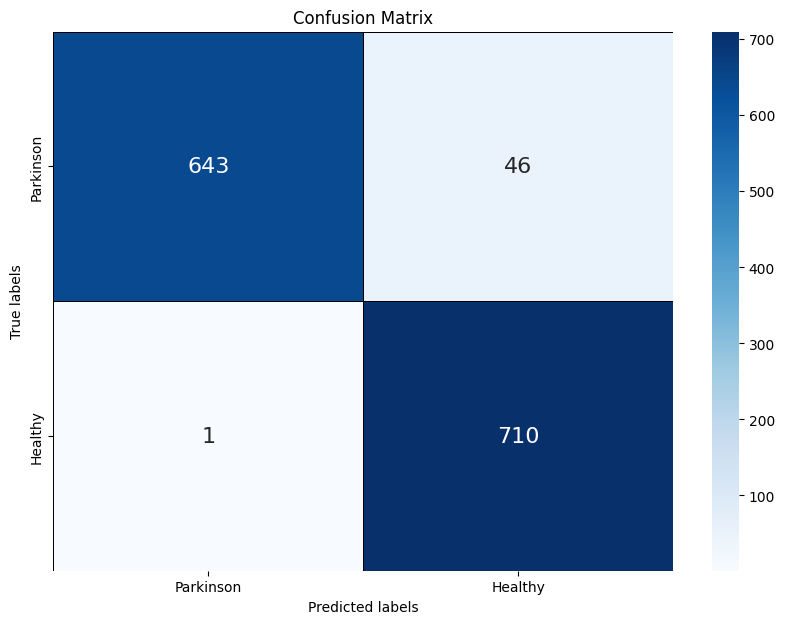

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix_res = confusion_matrix(y_test, y_test_pred_labels)

import pandas as pd
conf_matrix_df = pd.DataFrame(conf_matrix_res, index=subdirectories, columns=subdirectories)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            annot_kws={"size": 16}, linewidths=.5, linecolor='black')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


EDA

Images before and after enhancing brightness

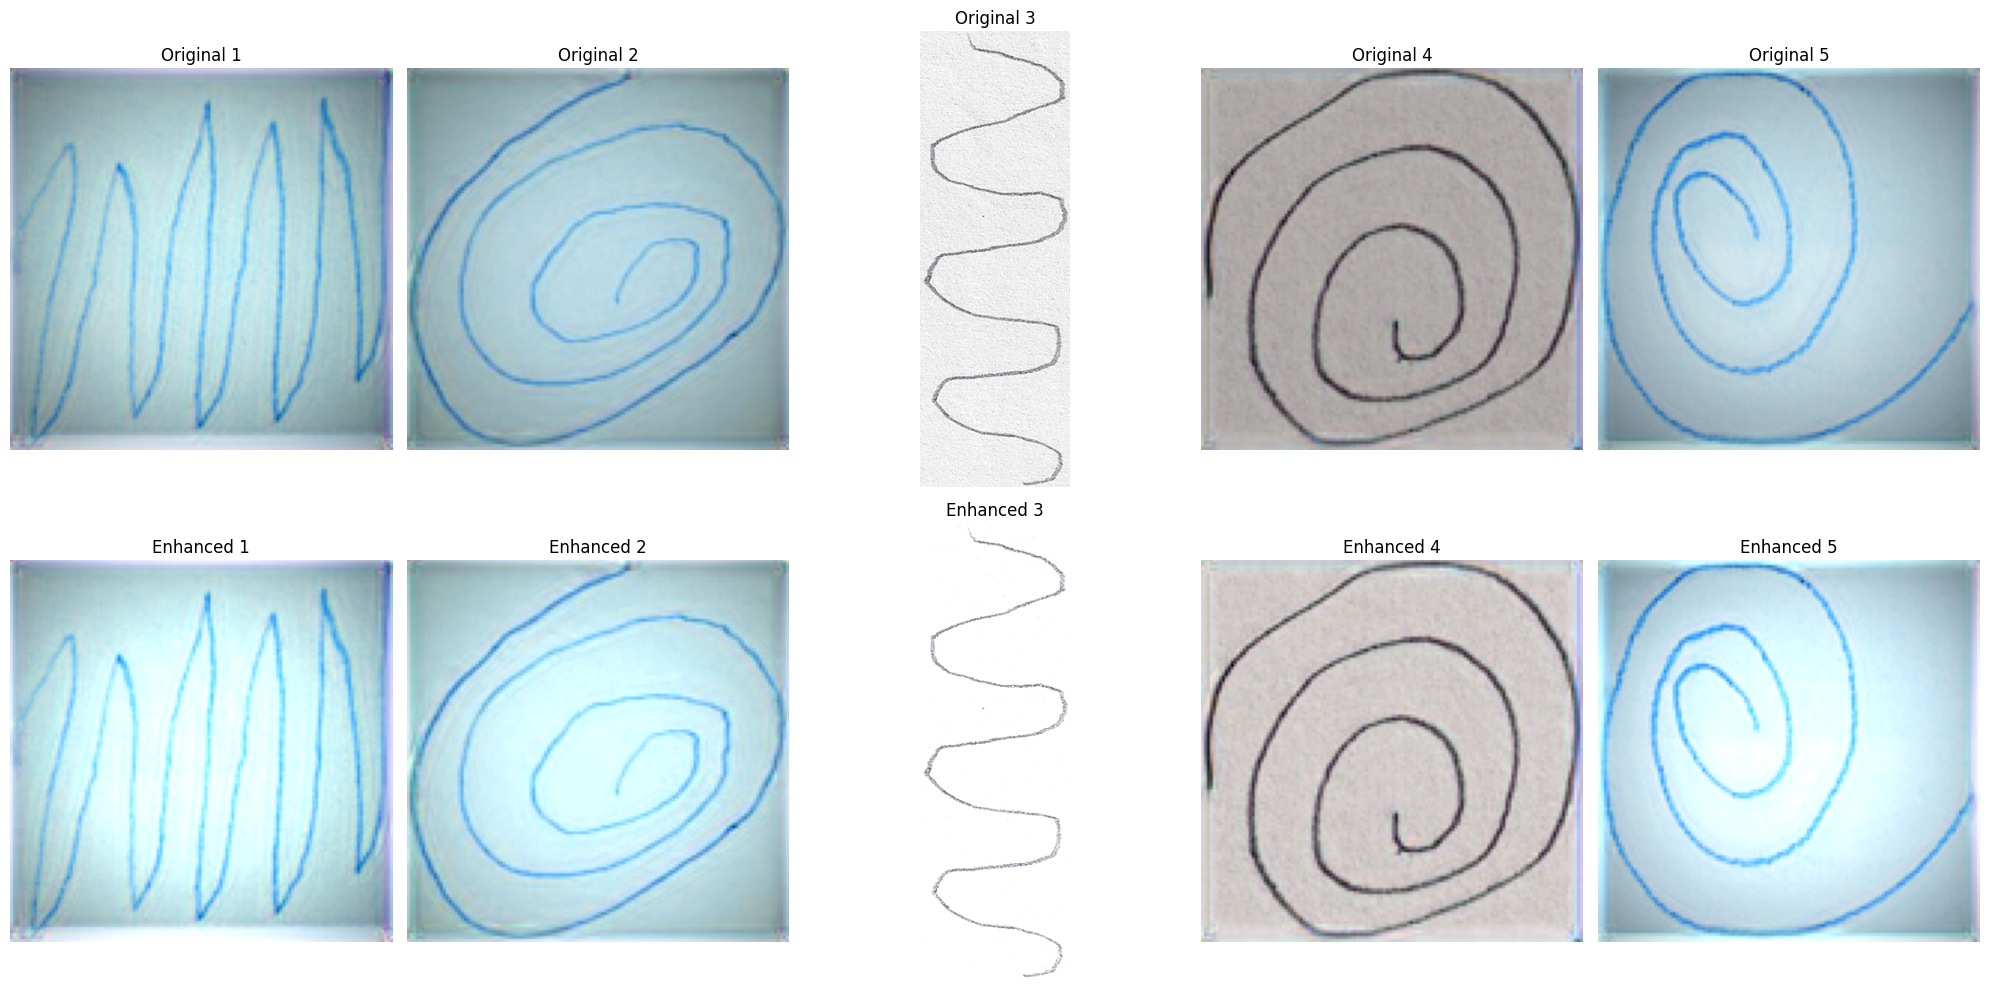

In [ ]:
import os
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

def enhance_contrast(image):


    #contrast
    enhancer = ImageEnhance.Brightness(image)




    return enhancer.enhance(1.2)


parent_dataset_folder = "/content/drive/MyDrive/SelectedImageFINAL"
subdirectories = ['Parkinson', 'Healthy']


image_paths = []
for subdir in subdirectories:
    subdir_path = os.path.join(parent_dataset_folder, subdir)
    for filename in os.listdir(subdir_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(subdir_path, filename))


if len(image_paths) < 5:
    raise ValueError("Not enough images in the dataset to display 5 random samples.")


selected_image_paths = random.sample(image_paths, 5)


fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i, img_path in enumerate(selected_image_paths):

    img = Image.open(img_path)

    enhanced_img = enhance_contrast(img)

    img = img.convert('RGB')
    enhanced_img = enhanced_img.convert('RGB')

    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original {i+1}')

    axes[1, i].imshow(enhanced_img)
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Enhanced {i+1}')

plt.tight_layout()
plt.show()


Image before and after applying histogram equalizing

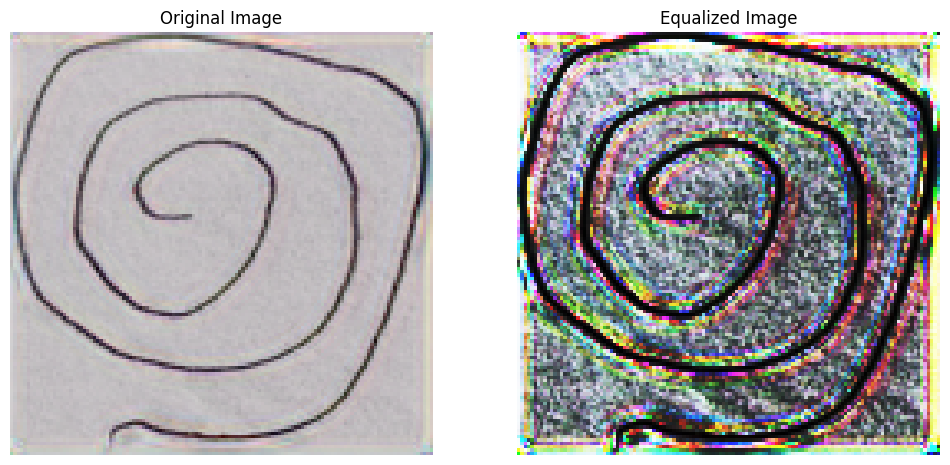

In [ ]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os
import random


target_size = (128, 128)

def preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    image = image.resize(target_size)
    image_equalized = ImageOps.equalize(image)
    image_array = np.array(image_equalized) / 255.0
    return image, image_equalized, image_array

def show_images_before_after(image_path, original_image, equalized_image):

    plt.figure(figsize=(12, 6))

    #original image
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')

    #equalized image
    plt.subplot(1, 2, 2)
    plt.title('Equalized Image')
    plt.imshow(equalized_image)
    plt.axis('off')

    plt.show()

parent_dataset_folder = "/content/drive/MyDrive/SelectedImageFINAL"
subdirectories = ['Parkinson', 'Healthy']

subdirectory = random.choice(subdirectories)
image_folder = os.path.join(parent_dataset_folder, subdirectory)
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

random_image_file = random.choice(image_files)
image_path = os.path.join(image_folder, random_image_file)

original_image, equalized_image, preprocessed_image_array = preprocess_image(image_path)
show_images_before_after(image_path, original_image, equalized_image)


EDA of metrics

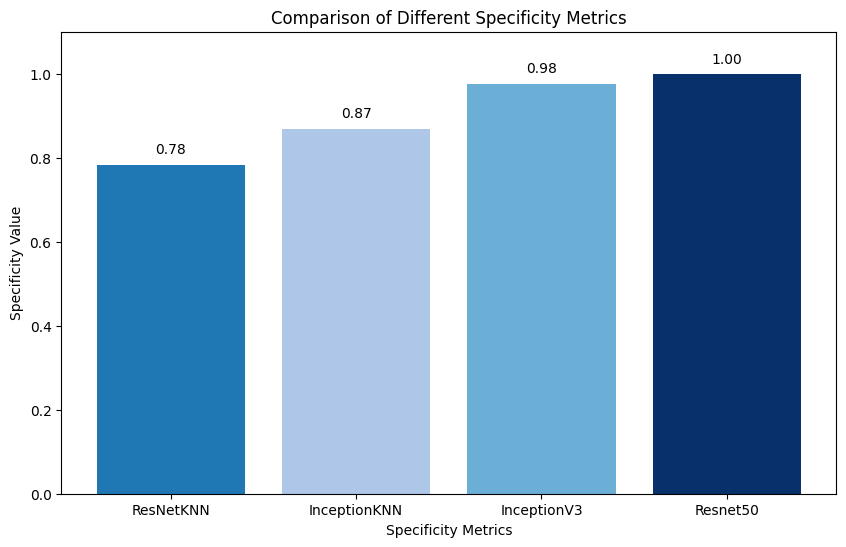

In [ ]:
import matplotlib.pyplot as plt

metrics = ['ResNetKNN', 'InceptionKNN', 'InceptionV3', 'Resnet50']
values = [specificityrk, specificityik, specificityinc, specificityres]

colors = ['#1f77b4', '#aec7e8', '#6baed6', '#08306b']

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors)

plt.xlabel('Specificity Metrics')
plt.ylabel('Specificity Value')
plt.title('Comparison of Different Specificity Metrics')
plt.ylim([0, 1.1])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}',
             ha='center', va='bottom', fontsize=10)

plt.show()

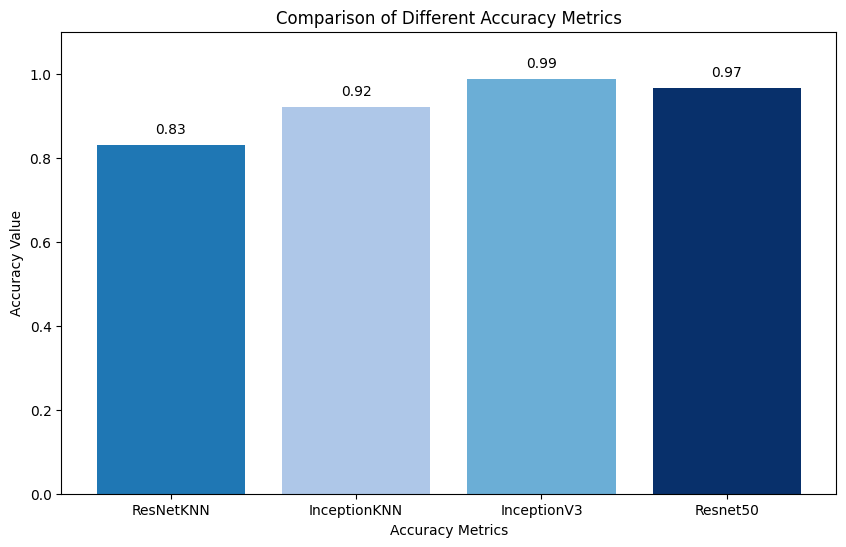

In [ ]:
import matplotlib.pyplot as plt


metrics = ['ResNetKNN', 'InceptionKNN', 'InceptionV3', 'Resnet50']
values = [test_accuracy_manual, test_accuracyik, test_accuracyinc, test_accuracyres]

colors = ['#1f77b4', '#aec7e8', '#6baed6', '#08306b']


plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors)


plt.xlabel('Accuracy Metrics')
plt.ylabel('Accuracy Value')
plt.title('Comparison of Different Accuracy Metrics')
plt.ylim([0, 1.1])


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}',
             ha='center', va='bottom', fontsize=10)


plt.show()


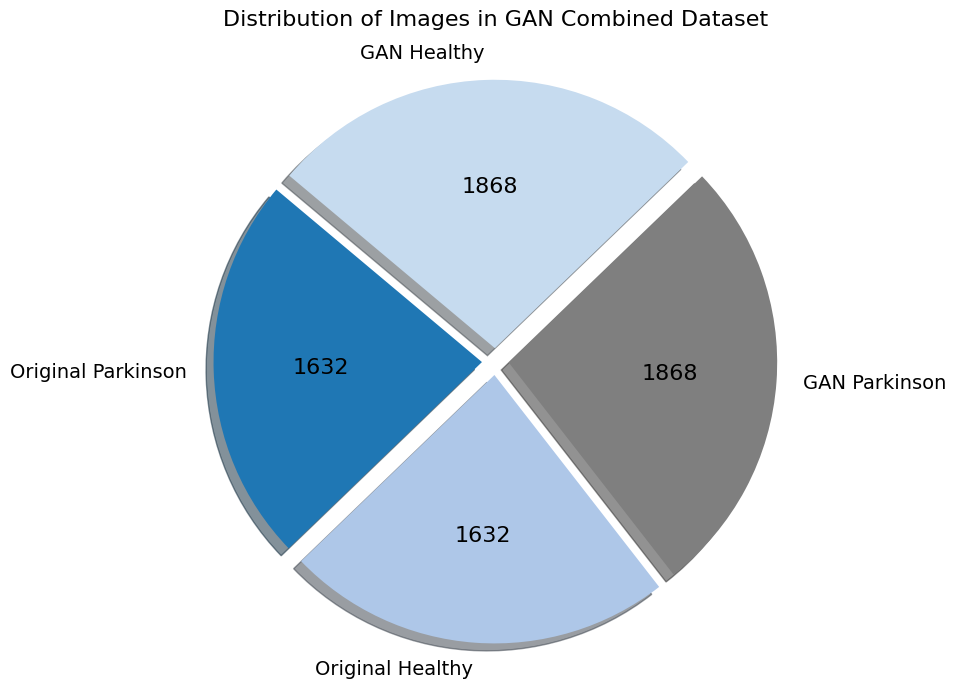

In [ ]:
import matplotlib.pyplot as plt


labels = ['Original Parkinson', 'Original Healthy', 'GAN Parkinson', 'GAN Healthy']
sizes = [1632, 1632, 1868, 1868]
colors = ['#1f77b4', '#aec7e8', '#7f7f7f', '#c6dbef']
explode = (0.05, 0.05, 0.05, 0.05)


def absolute_value(val):
    total = sum(sizes)
    count = total * val / 100
    if abs(count - round(count)) < 0.5:
        return f'{round(count)}'
    else:
        return f'{int(count)}'


plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors,
                                   autopct=absolute_value, shadow=True, startangle=140,
                                   textprops=dict(fontsize=14))


for text in texts:
    text.set_fontsize(14)


for autotext in autotexts:
    autotext.set_fontsize(16)


plt.axis('equal')


plt.title('Distribution of Images in GAN Combined Dataset', fontsize=16, pad=20)

plt.show()
